In [1]:
# ==============================================================================
# Cell 1: Setup, Imports, and Dependencies
# ==============================================================================

# Uncomment the lines below to install libraries if running in a new environment
# !pip install pandas numpy --quiet # Data handling
# !pip install torch transformers --quiet # Deep learning models (RoBERTa, GPT-2)
# !pip install scikit-learn seaborn --quiet # Machine learning and visualization
# !pip install nltk ipywidgets --quiet # Natural Language Toolkit and interactive widgets

# --- Imports ---
# Core data handling and processing libraries
import pandas as pd
import numpy as np
import os
import re
import requests
import shutil
import json
import random

# Machine Learning and NLP libraries
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
from sklearn.manifold import TSNE # For dimensionality reduction visualization
from sklearn.model_selection import train_test_split # For splitting data
from sklearn.linear_model import LogisticRegression # For classification
from sklearn.preprocessing import StandardScaler # For normalizing data before some models
from sklearn.metrics import classification_report, confusion_matrix # For evaluating classifiers
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction # For evaluating text similarity

# Visualization and Widget libraries
import matplotlib.pyplot as plt
import seaborn as sns # Enhanced statistical data visualization
from tqdm.auto import tqdm # Progress bar for loops
import ipywidgets as widgets # For creating interactive elements
from IPython.display import display, Markdown # For richer outputs

# Google Colab specific libraries
from google.colab import drive # For accessing Google Drive

print("✅ All libraries imported successfully.")

✅ All libraries imported successfully.


In [ ]:
# ==============================================================================
# Cell 2: Data Acquisition and Cleaning
# ==============================================================================
# This cell is responsible for downloading the raw book texts from Project
# Gutenberg and performing all the necessary cleaning steps. It produces the
# 'final_corpus.csv' file.
#
# Note: This cell needs to be run only once.

# --- Configuration ---
BOOKS_TO_DOWNLOAD = {
    'Fyodor Dostoevsky': [
        {'title': 'Crime and Punishment', 'id': 2554},
        {'title': 'The Brothers Karamazov', 'id': 28054},
    ],
    'Charles Dickens': [
        {'title': 'A Tale of Two Cities', 'id': 98},
        {'title': 'Great Expectations', 'id': 1400},
        {'title': 'Oliver Twist', 'id': 730},
    ]
}
PROCESSED_DATA_PATH = 'final_corpus.csv'

# --- Helper Functions ---
def download_gutenberg_text(book_id):
    """Downloads the plain text version of a book from Project Gutenberg."""
    url_patterns = [
        f'https://www.gutenberg.org/files/{book_id}/{book_id}-0.txt',
        f'https://www.gutenberg.org/cache/epub/{book_id}/pg{book_id}.txt',
        f'https://www.gutenberg.org/files/{book_id}/{book_id}.txt'
    ]
    for url in url_patterns:
        try:
            response = requests.get(url)
            if response.status_code == 200:
                print(f"  - Successfully downloaded from {url}")
                return response.content.decode('utf-8', errors='ignore')
        except requests.exceptions.RequestException:
            continue
    print(f"  - ERROR: Failed to download book with ID {book_id}.")
    return None

# Function added to make sure the files don't contain
def remove_table_of_contents(text):
    """Specifically finds and removes lines that look like a Table of Contents."""
    lines = text.splitlines()
    cleaned_lines = []
    toc_pattern = re.compile(r'^\s*(chapter|part|book|stave|epilogue)\s+([ivx\d]+|[a-zA-Z]+)?\s*(\.|\s)*\s*$', re.IGNORECASE)
    toc_pattern_2 = re.compile(r'.*\s\.{3,}\s*\d*\s*$|.*\s_+\s*\d*\s*$')
    for line in lines:
        if toc_pattern.match(line.strip()) or toc_pattern_2.match(line.strip()):
            continue
        if line.strip().lower() in ["contents", "table of contents"]:
            continue
        cleaned_lines.append(line)
    return "\n".join(cleaned_lines)

def clean_gutenberg_text(text, book_title):
    """The main cleaning pipeline, including TOC removal."""
    end_marker = re.search(r'\*\*\* END OF (THIS|THE) PROJECT GUTENBERG EBOOK .* \*\*\*', text, re.IGNORECASE)
    if end_marker: text = text[:end_marker.start()]
    start_marker = re.search(r'\*\*\* START OF (THIS|THE) PROJECT GUTENBERG EBOOK .* \*\*\*', text, re.IGNORECASE)
    if start_marker: text = text[start_marker.end():]
    text = remove_table_of_contents(text)
    text = re.sub(r'(\r\n|\n|\r){3,}', '\n\n', text).strip()
    return text

# In this analysis case, the decision to use variable paragraph-based chunks is a tradeoff:
# it preserves semantic meaning at the cost of absolute length consistency.
# The tokenizer crops oversize chunks and small ones are rejected by this helper function.
def segment_text(text, min_chunk_length=50):
    """Splits a long text into smaller chunks (paragraphs)."""
    if not isinstance(text, str): return []
    chunks = re.split(r'\n{2,}', text)
    return [chunk.strip() for chunk in chunks if len(chunk.strip()) >= min_chunk_length]

def normalize_text(text):
    """Performs basic text normalization."""
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def run_data_pipeline():
    """Main function for the data acquisition and cleaning pipeline."""
    processed_data = []
    print("Starting FINAL data acquisition and cleaning pipeline...")
    for author, books in BOOKS_TO_DOWNLOAD.items():
        print(f"\nProcessing books for: {author}")
        for book in books:
            title, book_id = book['title'], book['id']
            print(f"- Downloading '{title}' (ID: {book_id})...")
            raw_text = download_gutenberg_text(book_id)
            if not raw_text: continue
            cleaned_text = clean_gutenberg_text(raw_text, title)
            chunks = segment_text(cleaned_text)
            for chunk in chunks:
                normalized_chunk = normalize_text(chunk)
                processed_data.append({'author': author, 'book_title': title, 'text_chunk': normalized_chunk})
            print(f"  - Finished processing '{title}', created {len(chunks)} text chunks.")
    if not processed_data:
        print("\nPipeline finished, but no data was processed.")
        return
    processed_df = pd.DataFrame(processed_data)
    processed_df.to_csv(PROCESSED_DATA_PATH, index=False)
    print("\n--------------------")
    print("✅ Data acquisition and cleaning complete.")
    print(f"Final, cleaned data has been saved to '{PROCESSED_DATA_PATH}'")
    print("--------------------")

# --- Execute Pipeline ---
# To run, uncomment the line below
run_data_pipeline()


In [ ]:
# ==============================================================================
# Cell 3: Text Embedding
# ==============================================================================
# This cell loads the 'final_corpus.csv', runs the RoBERTa model to generate
# embeddings for each text chunk, and saves the result to
# 'stylistic_embeddings.npz'.
#
# NOTE: You only need to run this cell ONCE, after running Cell 2.
# Requires a GPU runtime for reasonable performance.

# --- Configuration ---
MODEL_NAME = 'roberta-base'
EMBEDDINGS_OUTPUT_PATH = 'stylistic_embeddings.npz'
BATCH_SIZE = 32

def generate_embeddings():
    """Main function to generate embeddings from the processed text data."""
    if not os.path.exists(PROCESSED_DATA_PATH):
        print(f"ERROR: Input file not found at '{PROCESSED_DATA_PATH}'")
        return
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModel.from_pretrained(MODEL_NAME)
    model.to(device)
    model.eval()
    print("Model and tokenizer loaded successfully.")
    df = pd.read_csv(PROCESSED_DATA_PATH)
    texts = df['text_chunk'].tolist()
    labels, author_names = pd.factorize(df['author'])
    author_mapping = {i: name for i, name in enumerate(author_names)}
    print(f"\nFound {len(texts)} text chunks to embed.")
    all_embeddings = []
    print(f"\nGenerating embeddings in batches of {BATCH_SIZE}...")
    for i in tqdm(range(0, len(texts), BATCH_SIZE)):
        batch_texts = texts[i:i + BATCH_SIZE]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(cls_embeddings)
    final_embeddings = np.vstack(all_embeddings)
    print(f"\n✅ Text embedding generation complete. Shape: {final_embeddings.shape}")
    np.savez_compressed(
        EMBEDDINGS_OUTPUT_PATH,
        embeddings=final_embeddings,
        labels=labels,
        author_mapping=author_mapping
    )
    print(f"Embeddings and labels saved to '{EMBEDDINGS_OUTPUT_PATH}'")

# --- Execute Embedding ---
# To run, uncomment the line below
generate_embeddings()


In [ ]:
# ==============================================================================
# Cell 4: Save Artifacts to Google Drive
# ==============================================================================
# This cell saves the two generated files ('final_corpus.csv' and
# 'stylistic_embeddings.npz') to your Google Drive for permanent storage.
#
# NOTE: You only need to run this cell ONCE, after running Cells 2 and 3.

def save_artifacts_to_drive():
    """Saves the generated data files to a specified Google Drive folder."""
    print("Mounting Google Drive...")
    drive.mount('/content/drive')
    project_folder = '/content/drive/MyDrive/NLP_Project'
    os.makedirs(project_folder, exist_ok=True)
    files_to_save = ['final_corpus.csv', 'stylistic_embeddings.npz']
    for file_name in files_to_save:
        source_path = os.path.join('/content/', file_name)
        destination_path = os.path.join(project_folder, file_name)
        if os.path.exists(source_path):
            shutil.copyfile(source_path, destination_path)
            print(f"✅ Successfully saved '{file_name}' to Google Drive!")
        else:
            print(f"⚠️ WARNING: File '{file_name}' not found. Skipping.")

# --- Execute Save ---
# To run, uncomment the line below
save_artifacts_to_drive()


In [2]:
# ==============================================================================
# Cell 5: Load Artifacts from Google Drive
# ==============================================================================
# In future sessions, you can START HERE. Run Cell 1, then run this cell to
# load your pre-processed data directly from Google Drive, skipping the
# time-consuming steps in Cells 2, 3, and 4.

def load_artifacts_from_drive():
    """Loads the data and embedding files from Google Drive into the session."""
    print("Mounting Google Drive...")
    drive.mount('/content/drive', force_remount=True)
    project_folder = '/content/drive/MyDrive/NLP_Project'
    corpus_path = os.path.join(project_folder, 'final_corpus.csv')
    embeddings_path = os.path.join(project_folder, 'stylistic_embeddings.npz')
    try:
        df = pd.read_csv(corpus_path)
        data = np.load(embeddings_path, allow_pickle=True)
        print("✅ All data and embeddings loaded successfully from Google Drive.")
        return df, data['embeddings'], data['labels'], data['author_mapping'].item()
    except FileNotFoundError as e:
        print(f"❌ ERROR: A required file was not found in your Drive: {e.filename}")
        return None, None, None, None

# --- Execute Load ---
df, embeddings, labels, author_mapping = load_artifacts_from_drive()


Mounting Google Drive...
Mounted at /content/drive
✅ All data and embeddings loaded successfully from Google Drive.


Starting t-SNE calculation... (This may take a few minutes)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 17100 samples in 0.009s...
[t-SNE] Computed neighbors for 17100 samples in 47.203s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17100
[t-SNE] Computed conditional probabilities for sample 2000 / 17100
[t-SNE] Computed conditional probabilities for sample 3000 / 17100
[t-SNE] Computed conditional probabilities for sample 4000 / 17100
[t-SNE] Computed conditional probabilities for sample 5000 / 17100
[t-SNE] Computed conditional probabilities for sample 6000 / 17100
[t-SNE] Computed conditional probabilities for sample 7000 / 17100
[t-SNE] Computed conditional probabilities for sample 8000 / 17100
[t-SNE] Computed conditional probabilities for sample 9000 / 17100
[t-SNE] Computed conditional probabilities for sample 10000 / 17100
[t-SNE] Computed conditional probabilities for sample 11000 / 17100
[t-SNE] Computed conditional probabilities for sample 12

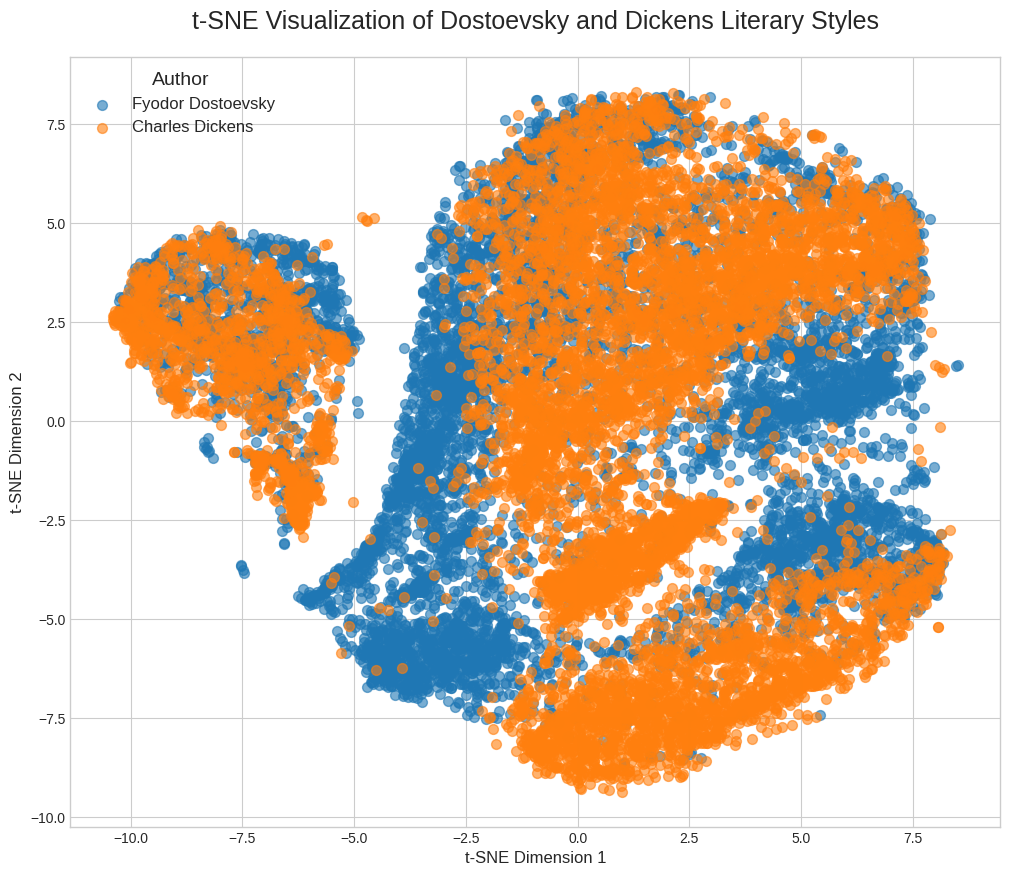

✅ t-SNE plot generated.


In [ ]:
# ==============================================================================
# Cell 6: t-SNE Visualization with Save/Load
# ==============================================================================
# This cell performs the t-SNE analysis and generates the visualization plot.
# It includes logic to save the results of the t-SNE calculation to
# avoid re-running the time-consuming process in future sessions.

def visualize_embeddings(embeddings, labels, author_mapping):
    """
    Calculates or loads t-SNE results and visualizes them.
    """
    project_folder = '/content/drive/MyDrive/NLP_Project'
    tsne_results_path = os.path.join(project_folder, 'tsne_reduced_embeddings.npy')

    # --- Check if t-SNE results are already saved ---
    if os.path.exists(tsne_results_path):
        print("Loading pre-calculated t-SNE results from Google Drive...")
        reduced_embeddings = np.load(tsne_results_path)
        print("✅ t-SNE results loaded successfully.")
    else:
        print("Starting t-SNE calculation... (This may take a few minutes)")
        # If not saved, run the t-SNE algorithm
        # n_components=2: Reduce to 2 dimensions for 2D plotting
        # perplexity=40: Relates to the number of nearest neighbors used in the algorithm.
        #              A common range is 5 to 50. 40 is a reasonable value for this dataset size.
        # random_state=42: Ensures reproducibility of the results.
        # max_iter=300: The number of iterations for the optimization.
        #             300 is often sufficient for convergence, but can be increased if needed.
        # verbose=1: Prints progress updates during the computation.
        tsne = TSNE(n_components=2, perplexity=40, random_state=42, max_iter=300, verbose=1)
        reduced_embeddings = tsne.fit_transform(embeddings)
        print("t-SNE calculation complete.")

        # --- Save the results for next time ---
        # Ensure the project folder exists before saving
        os.makedirs(project_folder, exist_ok=True)
        np.save(tsne_results_path, reduced_embeddings)
        print(f"✅ t-SNE results saved to '{tsne_results_path}' for future use.")

    # --- Plotting (remains the same) ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 10))
    colors = ['#1f77b4', '#ff7f0e']
    for label_id, author_name in author_mapping.items():
        points = reduced_embeddings[labels == label_id]
        ax.scatter(points[:, 0], points[:, 1], c=[colors[label_id]], label=author_name, alpha=0.6, s=50)

    ax.set_title('t-SNE Visualization of Dostoevsky and Dickens Literary Styles', fontsize=18, pad=20)
    ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
    ax.legend(title='Author', fontsize=12, title_fontsize=14, loc='best')
    ax.grid(True)
    plt.show()
    print("✅ t-SNE plot generated.")

# --- Execute Visualization ---
# Check if embeddings were successfully loaded in Cell 5 before attempting visualization
if embeddings is not None:
    visualize_embeddings(embeddings, labels, author_mapping)

Starting style classification...
Training data shape: (13680, 768), Testing data shape: (3420, 768)
Training complete.

--- Classification Report ---
                   precision    recall  f1-score   support

Fyodor Dostoevsky       0.92      0.91      0.92      1604
  Charles Dickens       0.92      0.93      0.93      1816

         accuracy                           0.92      3420
        macro avg       0.92      0.92      0.92      3420
     weighted avg       0.92      0.92      0.92      3420



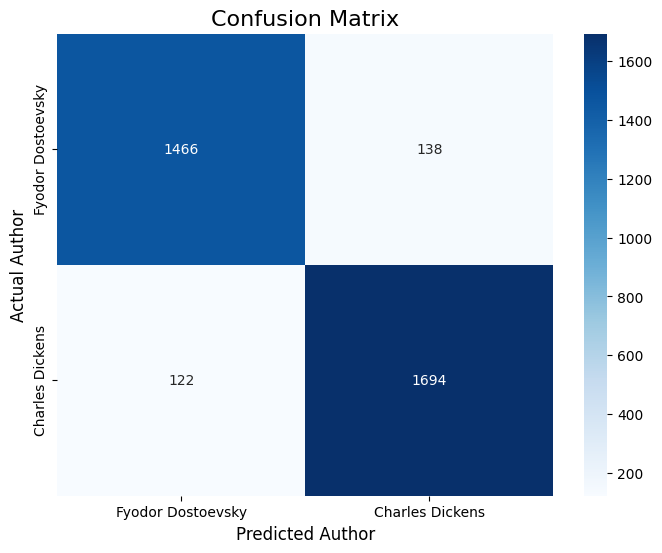

✅ Classification analysis complete.


In [4]:
# ==============================================================================
# Cell 7: Style Classification
# ==============================================================================
# This cell trains and evaluates the logistic regression classifier to get a
# quantitative measure of style separability.

def classify_styles(embeddings, labels, author_mapping):
    """Trains a classifier and evaluates its performance."""
    print("Starting style classification...")
    # Map numerical labels back to author names for readability in the report
    target_names = [author_mapping[i] for i in sorted(author_mapping.keys())]

    # Split data into training and testing sets
    # test_size=0.2: Use 20% of the data for testing, 80% for training. A common split.
    # random_state=42: Ensures the split is the same every time for reproducibility.
    # stratify=labels: Ensures that the proportion of each author is the same in both
    #                  the training and testing sets, important for imbalanced datasets.
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=0.2, random_state=42, stratify=labels
    )
    print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

    # Initialize and train the Logistic Regression classifier
    # C=1.0: Inverse of regularization strength. Smaller values specify stronger regularization.
    #        1.0 is a common default and works well here.
    # random_state=42: Ensures reproducibility of the model training.
    # max_iter=1000: Maximum number of iterations for the solver to converge.
    #              Increased from default (100) as embeddings are high-dimensional,
    #              and convergence might require more steps.
    # class_weight is set to balance in order for the model to train on two corpuses of the same size
    classifier = LogisticRegression(C=1.0, random_state=42, max_iter=1000, class_weight='balanced')
    classifier.fit(X_train, y_train)
    print("Training complete.")

    # Predict on the test set and evaluate
    y_pred = classifier.predict(X_test)

    # Generate and print the classification report (precision, recall, f1-score)
    report = classification_report(y_test, y_pred, target_names=target_names)
    print("\n--- Classification Report ---")
    print(report)

    # Generate and display the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('Actual Author', fontsize=12)
    plt.xlabel('Predicted Author', fontsize=12)
    plt.show()
    print("✅ Classification analysis complete.")

# --- Execute Classification ---
# Check if embeddings were successfully loaded in Cell 5 before attempting classification
# if embeddings is not None:
classify_styles(embeddings, labels, author_mapping)

Starting Concept Activation Vector (CAV) analysis...

--- Processing Concept: Psychological Focus (Dostoevsky) ---
CAV for 'Psychological Focus (Dostoevsky)' calculated successfully.
  - TCAV Score for Fyodor Dostoevsky: 0.490
  - TCAV Score for Charles Dickens: 0.359

--- Processing Concept: Social Commentary (Dickens) ---
CAV for 'Social Commentary (Dickens)' calculated successfully.
  - TCAV Score for Fyodor Dostoevsky: 0.333
  - TCAV Score for Charles Dickens: 0.498


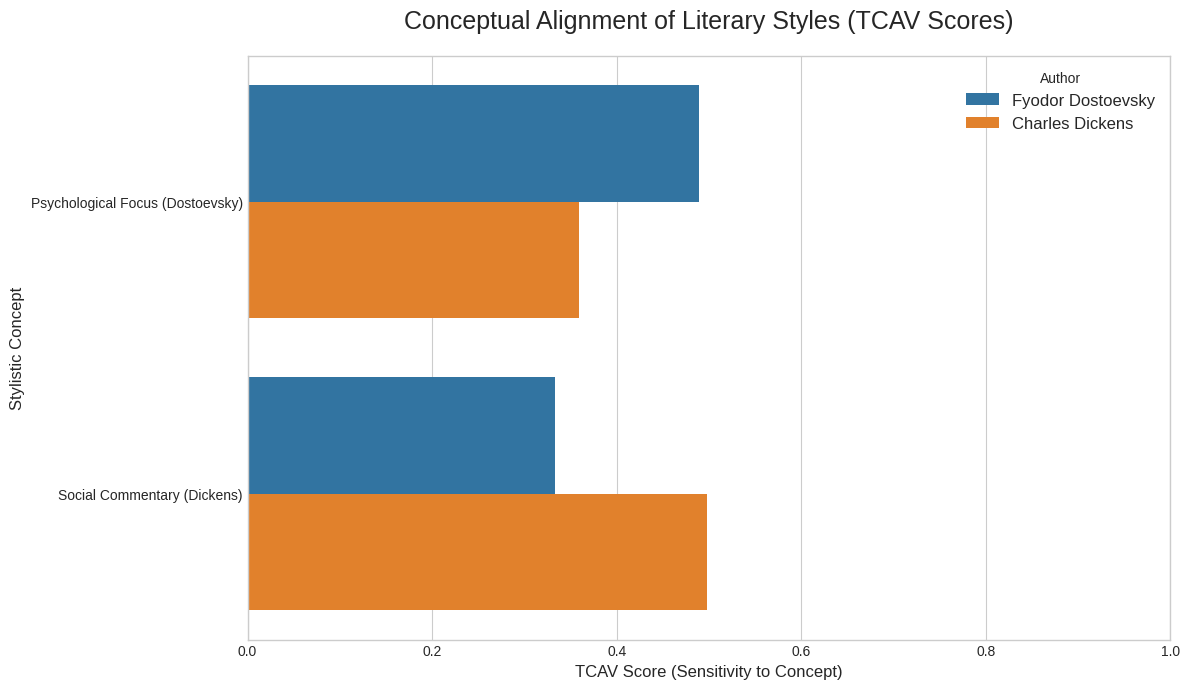

✅ CAV analysis complete.


In [ ]:
# ==============================================================================
# Cell 8: Concept Activation Vector (CAV) Analysis
# ==============================================================================
# This cell performs the CAV analysis to interpret the stylistic dimensions
# learned by the model.

def calculate_cavs_and_scores(df, embeddings, labels, author_mapping):
    """Calculates CAVs and TCAV scores for defined concepts."""
    print("Starting Concept Activation Vector (CAV) analysis...")

    # --- Define Stylistic Concepts and Associated Keywords ---
    # These concepts and keywords are chosen based on common literary analysis of
    # Dostoevsky and Dickens to represent their distinct themes and focuses.
    CONCEPTS = {
        "Psychological Focus (Dostoevsky)": ["soul", "conscious", "suffering", "guilt", "fever", "despair"],
        "Social Commentary (Dickens)": ["poverty", "gentleman", "london", "society", "injustice", "workhouse"]
    }

    # --- Configuration for CAV calculation ---
    # N_CONCEPT_EXAMPLES: Number of text chunks to sample that contain concept keywords.
    #                  Chosen to be large enough to capture the concept space, but small
    #                  enough to be computationally feasible.
    # N_RANDOM_EXAMPLES: Number of random text chunks to sample as a baseline.
    #                   Larger number helps ensure the CAV is concept-specific, not just
    #                   general text properties.
    N_CONCEPT_EXAMPLES = 100
    N_RANDOM_EXAMPLES = 500

    results = []

    def get_concept_examples(df, keywords, n_samples):
        """Helper to sample text chunks containing any of the given keywords."""
        pattern = '|'.join(keywords)
        matches = df[df['text_chunk'].str.contains(pattern, case=False, na=False)]
        if len(matches) == 0: return pd.DataFrame()
        # Sample without replacement to get unique examples
        return matches.sample(n=min(len(matches), n_samples), random_state=42)

    for concept_name, keywords in CONCEPTS.items():
        print(f"\n--- Processing Concept: {concept_name} ---")

        # Get example text chunks for the current concept and random examples
        concept_examples_df = get_concept_examples(df, keywords, N_CONCEPT_EXAMPLES)
        if concept_examples_df.empty:
            print(f"  - No examples found for concept '{concept_name}'. Skipping.")
            continue

        # Sample random examples excluding those already selected for the concept
        random_examples_df = df.drop(concept_examples_df.index).sample(n=min(len(df) - len(concept_examples_df), N_RANDOM_EXAMPLES), random_state=42)

        # Get the embeddings for the concept and random examples
        concept_embeddings = embeddings[concept_examples_df.index]
        random_embeddings = embeddings[random_examples_df.index]

        # Prepare data for the CAV classifier
        X_cav = np.vstack([concept_embeddings, random_embeddings])
        y_cav = np.hstack([np.ones(len(concept_embeddings)), np.zeros(len(random_embeddings))]) # 1 for concept, 0 for random

        # Scale embeddings before training the linear classifier for numerical stability
        scaler = StandardScaler()
        X_cav_scaled = scaler.fit_transform(X_cav)

        # Train a linear classifier (Logistic Regression) to find the CAV
        # The weights of this classifier represent the CAV, pointing in the direction
        # that maximally separates concept examples from random examples in the embedding space.
        # class_weight='balanced': Adjusts weights inversely proportional to class frequencies
        #                        to handle potential imbalance between concept and random examples.
        # max_iter=2000: Increased iterations for convergence on scaled high-dimensional data.
        cav_classifier = LogisticRegression(random_state=42, class_weight='balanced', max_iter=2000)
        cav_classifier.fit(X_cav_scaled, y_cav)

        # The CAV is the normalized weight vector of the classifier
        cav = cav_classifier.coef_[0] / np.linalg.norm(cav_classifier.coef_[0])
        print(f"CAV for '{concept_name}' calculated successfully.")

        # --- Calculate TCAV Scores for Each Author ---
        # TCAV (Testing with Concept Activation Vectors) score is the proportion
        # of an author's embeddings that align positively with the CAV.
        # It measures how sensitive an author's style is to the given concept.
        for label_id, author_name in author_mapping.items():
            author_embeddings = embeddings[labels == label_id]
            # Scale author embeddings using the same scaler fitted on CAV data
            author_embeddings_scaled = scaler.transform(author_embeddings)

            # Project author embeddings onto the CAV
            scores = np.dot(author_embeddings_scaled, cav)

            # Calculate the TCAV score (proportion of embeddings with positive projection)
            tcav_score = np.mean(scores > 0)

            results.append({'concept': concept_name, 'author': author_name, 'tcav_score': tcav_score})
            print(f"  - TCAV Score for {author_name}: {tcav_score:.3f}")

    if not results:
        print("\nNo results to plot.")
        return

    # Prepare results for plotting
    results_df = pd.DataFrame(results)

    # --- Visualize TCAV Scores ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    sns.barplot(data=results_df, x='tcav_score', y='concept', hue='author', orient='h')
    plt.title('Conceptual Alignment of Literary Styles (TCAV Scores)', fontsize=18, pad=20)
    plt.xlabel('TCAV Score (Sensitivity to Concept)', fontsize=12)
    plt.ylabel('Stylistic Concept', fontsize=12)
    plt.legend(title='Author', fontsize=12)
    plt.xlim(0, 1) # TCAV scores are probabilities, ranging from 0 to 1
    plt.tight_layout()
    plt.show()
    print("✅ CAV analysis complete.")

# --- Execute CAV Analysis ---
# Check if the dataframe was successfully loaded in Cell 5 before attempting CAV analysis
if df is not None:
    calculate_cavs_and_scores(df, embeddings, labels, author_mapping)

In [ ]:
# ==============================================================================
# Cell 9: Style Transfer Helper Functions (Improved Prompt)
# ==============================================================================
# This cell defines the core functions for interacting with the Gemini API.
# It features a prompt with negative constraints to guide the model
# effectively, especially for the more difficult Dostoevsky style.

# --- Global Configuration for Style Transfer ---
# Widget to securely input the Google AI API key
API_KEY_WIDGET = widgets.Password(
    value='',
    placeholder='Enter your Google AI API Key here',
    description='API Key:',
    disabled=False,
    style={'description_width': 'initial'}
)

# API endpoint URL for the Gemini 2.5 Flash model
API_URL = "https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash:generateContent?key="


def prepare_prompt(original_text, target_author):
    """
    --- V2: Creates a more advanced prompt with negative constraints. ---
    Generates a detailed prompt for the Gemini API, instructing it to rewrite
    the original_text in the style of target_author, including positive rules,
    negative constraints, and an example.
    """
    # Initial instruction setting the model's role and task
    prompt = f"You are an expert literary editor. Your task is to rewrite the given text in the distinct style of {target_author}, preserving the original meaning. Follow the stylistic rules precisely."

    # --- Define Stylistic Rules and Negative Constraints ---
    # These rules are derived from the analysis (t-SNE, CAV) and general literary
    # characteristics of each author.
    if target_author == "Fyodor Dostoevsky":
        style_description = (
            "**Rules for Dostoevsky's Style:**\n"
            "1.  **Focus:** Emphasize psychological depth, internal turmoil, and moral ambiguity.\n"
            "2.  **Sentences:** Use sentences that are often urgent, breathless, and sometimes fragmented to reflect a character's chaotic inner state.\n"
            "3.  **Vocabulary:** Choose words that convey intense emotion, feverishness, and philosophical weight (e.g., 'soul', 'torment', 'paradox', 'humiliation').\n"
            "4.  **AVOID:** Do NOT use overly ornate, descriptive language or long, flowing sentences typical of social commentary. Be direct and intense. " # Negative constraint to counter Dickens's style
        )
        # Provide a clear example demonstrating the desired style transfer
        example_original = "The man was poor and lived in a small, messy room. He was worried about his future."
        example_stylized = "A gnawing poverty, more a spiritual malady than a mere lack of coin, had confined him to a cramped, squalid garret that seemed an extension of his own disordered soul. A feverish anxiety for what was to come, a dread of the yawning abyss of the morrow, consumed his every waking thought."

    else: # Assumes the other author is Charles Dickens
        style_description = (
            "**Rules for Dickens's Style:**\n"
            "1.  **Focus:** Emphasize social observation, character quirks, and the atmosphere of the setting.\n"
            "2.  **Sentences:** Use long, rhythmic sentences with multiple clauses, often building to a satirical or sentimental point.\n"
            "3.  **Vocabulary:** Choose rich, descriptive, and sometimes theatrical words to paint a vivid picture of people and places (e.g., 'prodigious', 'benevolence', 'squalor', 'specter').\n"
            "4.  **AVOID:** Do NOT use overly simplistic, direct sentences. Be descriptive and elaborate." # Negative constraint to counter Dostoevsky's style
        )
        # Provide a clear example demonstrating the desired style transfer
        example_original = "The city was chaotic and full of desperate people."
        example_stylized = "It was a veritable maelstrom of a city, a sprawling, labyrinthine expanse wherein a multitude of souls, each etched with the grim signature of desperation, scurried through the grimy streets in a ceaseless, frantic dance of survival."

    # Construct the full prompt
    prompt += f"\n\n{style_description}"
    prompt += f"\n\n**Example Transformation:**\n---Original Text---\n{example_original}\n---Stylized Text---\n{example_stylized}\n---"
    prompt += f"\n\n**Your Task:** Now, apply these rules to the following text. Provide only the rewritten text.\n\n**Original Text:**\n{original_text}\n\n**Rewritten in the style of {target_author}:**"

    return prompt

def get_style_transfer_completion(prompt, api_key):
    """
    Calls the Gemini API to get the stylized text using a synchronous request.
    Sends the prepared prompt to the API and returns the generated text.
    Handles potential API errors and empty responses.
    """
    if not api_key:
        return "Error: API Key is missing."

    headers = {'Content-Type': 'application/json'}
    # Construct the request payload
    payload = {
        "contents": [{"parts": [{"text": prompt}]}],
        "generationConfig": {
            "temperature": 0.6, # Controls randomness. Lower values (closer to 0) make the output more deterministic.
                               # 0.6 provides some creativity while staying on task.
            "topK": 1, # Limits the sampling pool to the top K most likely tokens. 1 means only the most likely is considered.
            "topP": 1, # Limits the sampling pool to the smallest set of tokens whose cumulative probability exceeds P. 1 includes all tokens.
                      # Setting both topK and topP to 1 is deterministic given the temperature.
            "maxOutputTokens": 8192, # Maximum number of tokens the model should generate. Set high to accommodate potentially long text chunks.
        }
    }

    try:
        # Make the POST request to the Gemini API
        response = requests.post(f"{API_URL}{api_key}", headers=headers, data=json.dumps(payload))
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
        result = response.json()

        # Extract the generated text from the API response
        if 'candidates' in result and result['candidates'][0]['content']['parts'][0]['text']:
            return result['candidates'][0]['content']['parts'][0]['text']
        else:
            # Handle cases where the API returns an empty or structured but non-text response
            # This can happen if the input violates safety policies.
            return f"Error or empty response from API. The prompt may have been blocked or generated harmful content. Full response:\n{result}"

    except requests.exceptions.RequestException as e:
        # Handle network errors, timeouts, etc.
        return f"An API request error occurred: {e}"
    except Exception as e:
        # Handle any other unexpected errors during processing
        return f"A general error occurred during API interaction: {e}"

print("✅ Style transfer helper functions (V2 with improved prompt) defined successfully.")
print("Please enter your Google AI API Key below to proceed.")
display(API_KEY_WIDGET) # Display the widget for API key input

✅ Style transfer helper functions (V2 with improved prompt) defined successfully.
Please enter your Google AI API Key below to proceed.


Password(description='API Key:', placeholder='Enter your Google AI API Key here', style=DescriptionStyle(descr…

In [ ]:
# ==============================================================================
# Cell 10: Interactive Style Transfer Tool
# ==============================================================================
# Creates the interactive widget for experimenting with style transfer.

def create_interactive_style_transfer():
    """Creates and displays the full interactive widget."""
    if 'df' not in globals() or df is None:
        print("❌ ERROR: The dataframe 'df' is not loaded. Please run Cell 5.")
        return

    author_dropdown = widgets.Dropdown(options=df['author'].unique(), description='Original Author:', style={'description_width': 'initial'})
    text_area_original = widgets.Textarea(value='', placeholder='Text from the selected author will appear here.', description='Original Text:', layout={'height': '150px', 'width': '95%'}, disabled=True)
    text_area_stylized = widgets.Textarea(value='', placeholder='The rewritten text will appear here.', description='Stylized Text:', layout={'height': '200px', 'width': '95%'}, disabled=True)
    random_button = widgets.Button(description="Get Random Text")
    transfer_button = widgets.Button(description="Transfer Style", button_style='success')
    output_widget = widgets.Output()

    def get_random_text(_):
        author = author_dropdown.value
        sample = df[df['author'] == author].sample(1).iloc[0]
        text_area_original.value = sample['text_chunk']

    def run_transfer(_):
        with output_widget:
            output_widget.clear_output()
            if not API_KEY_WIDGET.value:
                print("❌ ERROR: Please enter your Google AI API Key in the widget from Cell 9.")
                return
            print("🔄 Performing style transfer... Please wait.")
            original_author = author_dropdown.value
            target_author = [auth for auth in df['author'].unique() if auth != original_author][0]
            prompt = prepare_prompt(text_area_original.value, target_author)
            stylized_text = get_style_transfer_completion(prompt, API_KEY_WIDGET.value)
            text_area_stylized.value = stylized_text
            output_widget.clear_output()
            print(f"✅ Style transfer complete. Target author: {target_author}")

    random_button.on_click(get_random_text)
    transfer_button.on_click(run_transfer)
    get_random_text(None)

    display(Markdown("### 🚀 Interactive Style Transfer Tool"))
    display(Markdown("Select an author, get a random text, and then transfer its style."))
    display(widgets.HBox([author_dropdown, random_button]))
    display(text_area_original)
    display(transfer_button)
    display(text_area_stylized)
    display(output_widget)

# --- Run the Interactive Tool ---
create_interactive_style_transfer()


### 🚀 Interactive Style Transfer Tool

Select an author, get a random text, and then transfer its style.

Textarea(value='it happened once or twice, however, that pulcheria alexandrovna gave such a turn to the conver…

Button(button_style='success', description='Transfer Style', style=ButtonStyle())

Textarea(value='', description='Stylized Text:', disabled=True, layout=Layout(height='200px', width='95%'), pl…

Output()

In [ ]:
# ==============================================================================
# Cell 11: Quantitative Evaluation of Style Transfer (Corrected)
# ==============================================================================
# This cell systematically evaluates the
# style transfer performance using automated metrics for Style Strength,
# Content Preservation, and Fluency.

# --- Configuration ---
# N_EVAL_SAMPLES: Number of samples to evaluate from each author.
#                 Choosing a moderate number balances evaluation coverage
#                 with the time and cost of API calls. 25 provides a
#                 reasonable sample size for this demonstration.
N_EVAL_SAMPLES = 25
EVALUATION_RESULTS_PATH = 'evaluation_results.csv'

# --- New Evaluation Functions ---
def calculate_perplexity(text, model, tokenizer, device):
    """
    Calculates the perplexity of a given text, truncating if necessary.
    Perplexity is a measure of how well a probability model predicts a sample.
    Lower perplexity indicates the model is better at predicting the next token,
    suggesting the text is more fluent and natural according to the language model.
    """
    if not text: return float('inf') # Handle empty input

    # --- FIX 1: Truncate the input to the model's max length ---
    # The tokenizer will handle cutting the text to the max length (1024 for gpt2)
    # This prevents errors with inputs exceeding the model's sequence length limit.
    encodings = tokenizer(text, return_tensors='pt', truncation=True, max_length=model.config.n_positions)

    input_ids = encodings.input_ids.to(device)
    target_ids = input_ids.clone() # For perplexity calculation, the target is the input itself

    # Calculate loss (negative log likelihood)
    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

    # Perplexity is e raised to the power of the average negative log likelihood (loss)
    ppl = torch.exp(outputs.loss)
    return ppl.item()

def run_quantitative_evaluation():
    """
    Main function to run the full quantitative evaluation pipeline.
    Evaluates style transfer by:
    1. **Style Strength:** Classifying the stylized text using the trained RoBERTa classifier.
       A high classification accuracy towards the *target* author indicates successful style transfer.
    2. **Content Preservation:** Calculating the self-BLEU score between the original and stylized text.
       BLEU (Bilingual Evaluation Understudy) measures the similarity of n-grams between a candidate
       text and reference texts. Self-BLEU here uses the original as the reference,
       indicating how much original content is preserved.
    3. **Fluency:** Calculating the perplexity of the stylized text using a language model (GPT-2).
       Lower perplexity suggests the stylized text is more fluent and grammatically correct.
    """
    if 'df' not in globals() or df is None:
        print("❌ ERROR: The dataframe 'df' is not loaded. Please run Cell 5.")
        return
    if not API_KEY_WIDGET.value:
        print("❌ ERROR: Please enter your Google AI API Key in the widget from Cell 9.")
        return

    print("--- Starting Quantitative Evaluation ---")
    # Determine the device (GPU or CPU) to use for models
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # --- Load Models for Evaluation ---
    print("Loading evaluation models...")
    # RoBERTa for generating embeddings to classify style
    roberta_tokenizer = AutoTokenizer.from_pretrained('roberta-base')
    roberta_model = AutoModel.from_pretrained('roberta-base')
    roberta_model.to(device); roberta_model.eval() # Move model to device and set to evaluation mode

    # GPT-2 for calculating perplexity (fluency)
    ppl_tokenizer = AutoTokenizer.from_pretrained('gpt2')
    ppl_model = AutoModelForCausalLM.from_pretrained('gpt2')
    ppl_model.to(device); ppl_model.eval() # Move model to device and set to evaluation mode
    print("✅ Evaluation models loaded.")

    # --- Train Style Classifier for Style Strength Metric ---
    # Use the embeddings and labels loaded in Cell 5 to train a classifier
    # that can distinguish between the original authors' styles. This trained
    # classifier is then used to predict the author of the *stylized* text.
    print("Training style classifier...")
    # C=1.0, random_state=42, max_iter=1000: Hyperparameters for Logistic Regression
    # (See comments in Cell 7 for detailed explanation of choices)
    style_classifier = LogisticRegression(C=1.0, random_state=42, max_iter=1000)
    # Fit the classifier on the full dataset embeddings and labels
    style_classifier.fit(embeddings, labels)
    print("✅ Style classifier trained.")

    # --- Prepare Evaluation Tasks ---
    # Define the two directions of style transfer to evaluate
    evaluation_tasks = [
        {'original_df': df[df['author'] == 'Fyodor Dostoevsky'].sample(N_EVAL_SAMPLES, random_state=42), 'target_author': 'Charles Dickens'},
        {'original_df': df[df['author'] == 'Charles Dickens'].sample(N_EVAL_SAMPLES, random_state=42), 'target_author': 'Fyodor Dostoevsky'}
    ]
    results = [] # List to store results for each sample

    # --- FIX 2: Add a smoothing function for more robust BLEU scores ---
    # BLEU score can be zero if there are no overlapping n-grams.
    # Smoothing methods adjust the score to avoid division by zero and
    # provide more meaningful scores for short or dissimilar texts.
    smoother = SmoothingFunction().method1 # Method1 adds a small constant to counts

    # --- Run Evaluation Loop ---
    for task in evaluation_tasks:
        original_author = task['original_df']['author'].iloc[0]
        target_author = task['target_author']
        print(f"\n🔄 Evaluating transfer from {original_author} to {target_author}...")

        # Iterate through each sample text for the current task
        for _, row in tqdm(task['original_df'].iterrows(), total=len(task['original_df'])):
            original_text = row['text_chunk']

            # Perform style transfer using the Gemini API
            prompt = prepare_prompt(original_text, target_author)
            stylized_text = get_style_transfer_completion(prompt, API_KEY_WIDGET.value)

            # Skip evaluation for samples where API call failed
            if stylized_text.startswith("Error"):
                print(f"  - Skipping sample due to API error: {stylized_text[:100]}...")
                continue

            # --- Calculate Style Strength ---
            # Get embedding of the stylized text using RoBERTa
            inputs = roberta_tokenizer(stylized_text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
            with torch.no_grad():
                outputs = roberta_model(**inputs)
            stylized_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()

            # Predict the author of the stylized text using the trained classifier
            predicted_label = style_classifier.predict(stylized_embedding)[0]
            # Get the numerical label for the target author
            target_label = [k for k, v in author_mapping.items() if v == target_author][0]

            # --- Calculate Content Preservation (self-BLEU) ---
            # Compare the stylized text to the original text
            # weights=(0.5, 0.5, 0, 0): Use BLEU-2 (bigrams and unigrams), giving equal weight to both.
            #                          This captures some phrase-level similarity.
            self_bleu_score = sentence_bleu([original_text.split()], stylized_text.split(), weights=(0.5, 0.5, 0, 0), smoothing_function=smoother)


            # --- Calculate Fluency (Perplexity) ---
            # Evaluate the perplexity of the stylized text using GPT-2
            perplexity_score = calculate_perplexity(stylized_text, ppl_model, ppl_tokenizer, device)

            # Append the results for this sample
            results.append({
                'From': original_author, 'To': target_author,
                'Style Accuracy': 1 if predicted_label == target_label else 0, # Binary score: 1 if predicted correctly, 0 otherwise
                'self-BLEU': self_bleu_score,
                'Perplexity': perplexity_score
            })

    if not results:
        print("\nNo results to display. Evaluation tasks may have failed.")
        return

    # --- Summarize and Save Results ---
    results_df = pd.DataFrame(results)

    # Calculate average scores for each transfer direction
    final_scores = results_df.groupby(['From', 'To']).mean()

    # Save the results DataFrame to a CSV file
    final_scores.to_csv(EVALUATION_RESULTS_PATH)
    print(f"\n✅ Evaluation results saved to '{EVALUATION_RESULTS_PATH}'")

    # Copy the results file to Google Drive for persistence
    project_folder = '/content/drive/MyDrive/NLP_Project'
    # Ensure the drive is mounted if it hasn't been already (redundant check but safe)
    # try: drive.mount('/content/drive') except: pass
    if os.path.exists(project_folder):
        shutil.copyfile(EVALUATION_RESULTS_PATH, os.path.join(project_folder, EVALUATION_RESULTS_PATH))
        print(f"✅ Copied results to Google Drive.")
    else:
        print(f"⚠️ Warning: Google Drive project folder '{project_folder}' not found. Could not copy results.")


    # --- Display Results ---
    display(Markdown("### 📊 Quantitative Evaluation Results (Averages)"))
    display(final_scores)

# To run, uncomment the line below
run_quantitative_evaluation()

--- Starting Quantitative Evaluation ---
Loading evaluation models...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Evaluation models loaded.
Training style classifier...
✅ Style classifier trained.

🔄 Evaluating transfer from Fyodor Dostoevsky to Charles Dickens...


  0%|          | 0/25 [00:00<?, ?it/s]


🔄 Evaluating transfer from Charles Dickens to Fyodor Dostoevsky...


  0%|          | 0/25 [00:00<?, ?it/s]


✅ Evaluation results saved to 'evaluation_results.csv'
✅ Copied results to Google Drive.


### 📊 Quantitative Evaluation Results (Averages)

,,Style Accuracy,self-BLEU,Perplexity
From,To,,,
Charles Dickens,Fyodor Dostoevsky,0.20,0.065790,70.789149
Fyodor Dostoevsky,Charles Dickens,0.84,0.069463,45.720008


In [ ]:
# ==============================================================================
# Cell 12: Display Saved Evaluation Results
# ==============================================================================
# In future sessions, after running Cell 1 (Setup) and Cell 5 (Load Artifacts),
# you can run this cell to instantly display the results from your last
# quantitative evaluation without re-running the entire process.

def display_saved_results():
    """Loads and displays the saved evaluation results table from Google Drive."""

    # Define the path to the results file in your Google Drive
    project_folder = '/content/drive/MyDrive/NLP_Project'
    results_path = os.path.join(project_folder, 'evaluation_results.csv')

    # Check if the file exists before trying to load it
    if not os.path.exists(results_path):
        print(f"❌ ERROR: Results file not found at '{results_path}'.")
        print("Please run the full quantitative evaluation (Cell 11) at least once to generate the file.")
        return

    print(f"Loading saved evaluation results from: {results_path}")

    # Load the CSV file into a pandas DataFrame
    saved_results_df = pd.read_csv(results_path)

    # Display the results in a clean format
    display(Markdown("### 📊 Saved Quantitative Evaluation Results (Averages)"))
    # Set the 'From' and 'To' columns as the index for better readability
    display(saved_results_df.set_index(['From', 'To']))

    print("\n--- Interpretation ---")
    print("Higher 'Style Accuracy' is better (Max 1.0).")
    print("Higher 'self-BLEU' is better (Max 1.0, indicates more content overlap).")
    print("Lower 'Perplexity' is better (Indicates more fluent text).")

# --- Run Display ---
# This line should have NO indentation before it.
display_saved_results()


Loading saved evaluation results from: /content/drive/MyDrive/NLP_Project/evaluation_results.csv


### 📊 Saved Quantitative Evaluation Results (Averages)

,,Style Accuracy,self-BLEU,Perplexity
From,To,,,
Charles Dickens,Fyodor Dostoevsky,0.20,0.065790,70.789149
Fyodor Dostoevsky,Charles Dickens,0.84,0.069463,45.720008



--- Interpretation ---
Higher 'Style Accuracy' is better (Max 1.0).
Higher 'self-BLEU' is better (Max 1.0, indicates more content overlap).
Lower 'Perplexity' is better (Indicates more fluent text).
